In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchsummary import summary
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


Import libraries


In [2]:
testset = CIFAR100(root = 'data/', train = False, transform = ToTensor())
dataset = CIFAR100(root = 'data/', download = True, transform = ToTensor())


Files already downloaded and verified


Downloading the dataset

In [3]:
image_size = 220

In [4]:

print(len(testset))
print(len(dataset))


10000
50000


 Length of the training datasets and the test datasets

In [5]:

classes = dataset.classes
print('class number:', len(classes))
print('class Name:',classes)

class number: 100
class Name: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'ward

Names of classes

In [6]:
sampleidx = 29
sampleimg, samplelabel = dataset[sampleidx]  
print(f"Image shape: {sampleimg.shape}")  

Image shape: torch.Size([3, 32, 32])


Get samples from the dataset and see the image shape

In [7]:
 
torch.manual_seed(40)  
valsize = 20000  
trainsize = len(dataset) - valsize  




To ensure repeatable results, set the random seed

In [8]:

traindataset, valdataset = random_split(dataset, [trainsize, valsize])  


Divide into training set and validation set

In [9]:
batch_size = 64
trainloader = DataLoader(traindataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)  
valloader = DataLoader(valdataset, batch_size=batch_size, num_workers=3, pin_memory=True)  
testloader = DataLoader(dataset, batch_size=batch_size, num_workers=3, pin_memory=True)

Defining a data loader

batch image shape: torch.Size([64, 3, 32, 32])


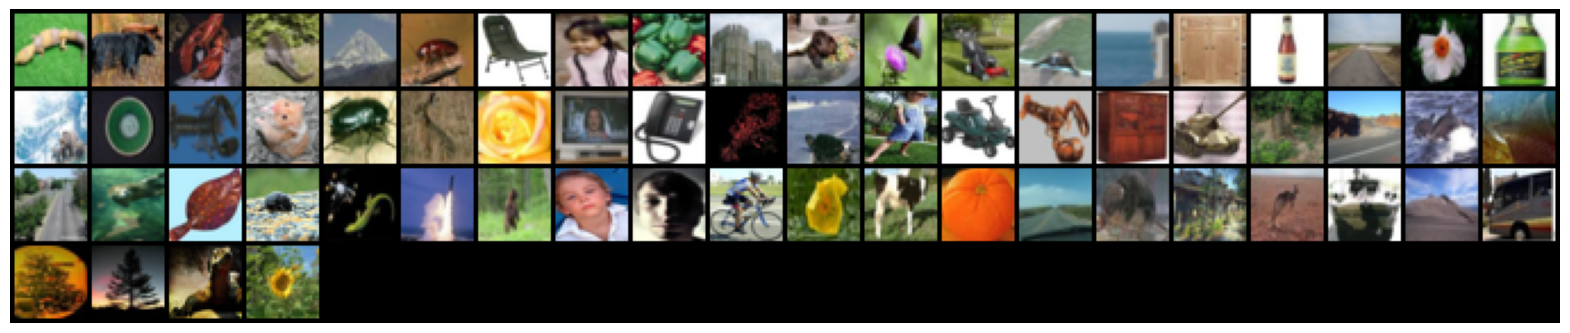

In [10]:

for images, i in trainloader:  
    print(f"batch image shape: {images.shape}")  
    plt.figure(figsize=(20, 10))  
    plt.axis('off')  
    plt.imshow(make_grid(images, nrow=20).permute(1, 2, 0))  
    break

Visualize a batch of images in the training set

In [11]:

def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Device Management

In [12]:

def move_to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [move_to_device(x, device) for x in data]
    return data.to(device)

Move data to device

In [13]:

class DeviceDataLoader:
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield move_to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)


Encapsulating data loaders

In [14]:
class Cifar100Model(nn.Module):
    def __init__(self):
        super(Cifar100Model, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64x16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 128x8x8

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 256x4x4
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*4*4, 1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, 100) 
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

This code defines a neural network model class called Cifar100Model, which is inherited from PyTorch's nn.Module class. This model is mainly used for image classification tasks, especially for the CIFAR-100 dataset.

In [15]:

def training_step(model, batch, optimizer):
    images, labels = batch
    out = model(images)
    loss = F.cross_entropy(out, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()


Training steps

In [16]:

@torch.no_grad()
def validation_step(model, batch):
    images, labels = batch
    out = model(images)
    loss = F.cross_entropy(out, labels)
    _, preds = torch.max(out, dim=1)
    accuracy = torch.sum(preds == labels).item() / len(preds)
    return {'val_loss': loss.item(), 'val_acc': accuracy}


Verification Steps

In [17]:

@torch.no_grad()
def evaluate(model, val_loader):
    results = [validation_step(model, batch) for batch in val_loader]
    return {
        'val_loss': sum([x['val_loss'] for x in results]) / len(results),
        'val_acc': sum([x['val_acc'] for x in results]) / len(results)
    }



Evaluate the model

In [18]:

def fit(model, train_loader, val_loader, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = training_step(model, batch, optimizer)
            train_losses.append(loss)
        
        model.eval()
        result = evaluate(model, val_loader)
        avg_train_loss = sum(train_losses) / len(train_losses)
        print(f"Epoch {epoch+1}/{epochs}, train_loss: {avg_train_loss:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")


Train the model

In [19]:

device = get_device()
model = Cifar100Model().to(device)

train_loader = DeviceDataLoader(trainloader, device)
val_loader = DeviceDataLoader(valloader, device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


1.Determine the compute device (CPU or GPU) to use for training and inference.
2.Create a Cifar100Model instance and move it to the specified device.
3.Create a PyTorch DataLoader for the training and validation sets and move the data to the specified device.
4.Create an optimizer that uses the SGD optimization algorithm to update the model parameters during training

In [20]:

fit(model, train_loader, val_loader, optimizer, epochs=5)

Epoch 1/5, train_loss: 4.6056, val_loss: 4.6056, val_acc: 0.0104
Epoch 2/5, train_loss: 4.6055, val_loss: 4.6056, val_acc: 0.0104
Epoch 3/5, train_loss: 4.6055, val_loss: 4.6056, val_acc: 0.0104
Epoch 4/5, train_loss: 4.6055, val_loss: 4.6056, val_acc: 0.0104
Epoch 5/5, train_loss: 4.6055, val_loss: 4.6056, val_acc: 0.0104


Start training

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5, train_loss: 4.3787, val_loss: 4.1649, val_acc: 0.0382
Epoch 2/5, train_loss: 4.1647, val_loss: 4.1189, val_acc: 0.0494
Epoch 3/5, train_loss: 4.0424, val_loss: 3.9100, val_acc: 0.0654
Epoch 4/5, train_loss: 3.8770, val_loss: 3.7705, val_acc: 0.0780
Epoch 5/5, train_loss: 3.6658, val_loss: 3.5731, val_acc: 0.1049


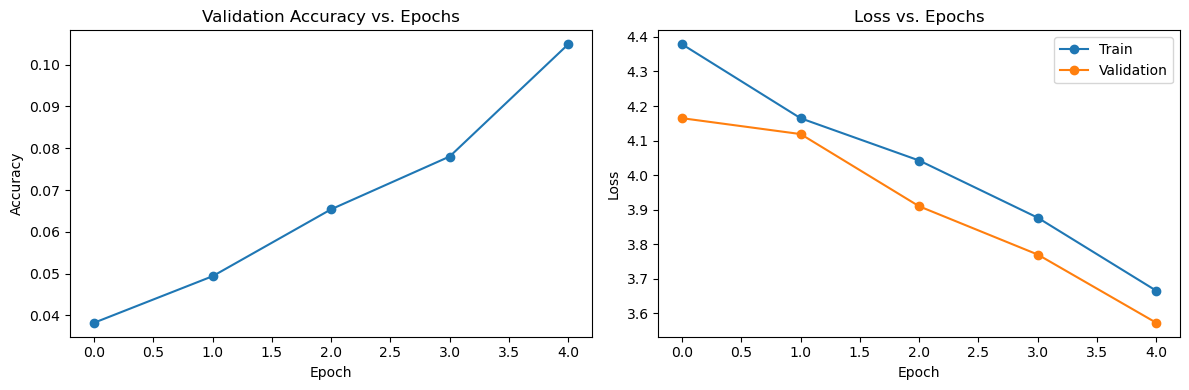

Test Loss (VGG): 3.5731
Test Accuracy (VGG): 0.1049
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]    

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary


class VGGModel(nn.Module):
    def __init__(self, num_classes=100):
        super(VGGModel, self).__init__()
        self.features = self._make_layers([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'])
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096), nn.ReLU(True), nn.Dropout(),
            nn.Linear(4096, 4096), nn.ReLU(True), nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)


epochs = 5
learning_rate = 0.001
grad_clip_value = 0.1
batch_size = 64


transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = CIFAR100(root='data/', train=True, transform=transform, download=True)
val_dataset = CIFAR100(root='data/', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


vgg_model = VGGModel().to(device)


optimizer = torch.optim.Adam(vgg_model.parameters(), lr=learning_rate, weight_decay=1e-4)


@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    total_loss, total_acc = 0, 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        out = model(images)
        loss = F.cross_entropy(out, labels)
        _, preds = torch.max(out, dim=1)
        total_loss += loss.item()
        total_acc += torch.sum(preds == labels).item() / len(labels)
    return {'val_loss': total_loss / len(data_loader), 'val_acc': total_acc / len(data_loader)}


def fit(model, train_loader, val_loader, optimizer, epochs, grad_clip=None):
    history = []
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(loss.item())
        
        result = evaluate(model, val_loader)
        avg_train_loss = sum(train_losses) / len(train_losses)
        history.append({
            'train_loss': avg_train_loss,
            'val_loss': result['val_loss'],
            'val_acc': result['val_acc']
        })
        print(f"Epoch {epoch+1}/{epochs}, train_loss: {avg_train_loss:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
    return history


training_history_vgg = fit(vgg_model, train_loader, val_loader, optimizer, epochs, grad_clip=grad_clip_value)


def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    
    ax1.plot([x['val_acc'] for x in history], '-o')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Validation Accuracy vs. Epochs')
    
    
    ax2.plot([x['train_loss'] for x in history], '-o', label='Train')
    ax2.plot([x['val_loss'] for x in history], '-o', label='Validation')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss vs. Epochs')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


plot_metrics(training_history_vgg)


test_metrics_vgg = evaluate(vgg_model, val_loader)
print(f"Test Loss (VGG): {test_metrics_vgg['val_loss']:.4f}")
print(f"Test Accuracy (VGG): {test_metrics_vgg['val_acc']:.4f}")


torch.save(vgg_model.state_dict(), 'VGGModel.pth')


summary(vgg_model, input_size=(3, 32, 32))


In general, this code implements an image classification model based on VGG16, completes the functions of loading the dataset, training and evaluating the model, and saving the model. It can be used as a basic template for deep learning image classification tasks for readers to further learn and improve.

In [ ]:

resnet18_model = model.resnet18(pretrained=False)
resnet18_model.fc = nn.Linear(512, 100)  #
resnet18_model = resnet18_model.to(device)


optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


train_model(resnet18_model, train_loader, val_loader, criterion, optimizer, epochs=10)

Define ResNet18 model

In [ ]:

resnet34_model = models.resnet34(pretrained=False)
resnet34_model.fc = nn.Linear(512, 100) 
resnet34_model = resnet34_model.to(device)

optimizer = optim.Adam(resnet34_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_model(resnet34_model, train_loader, val_loader, criterion, optimizer, epochs=10)

Define  ResNet34  model

In [ ]:

resnet50_model = models.resnet50(pretrained=False)
resnet50_model.fc = nn.Linear(2048, 100)  
resnet50_model = resnet50_model.to(device)


optimizer = optim.Adam(resnet50_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


train_model(resnet50_model, train_loader, val_loader, criterion, optimizer, epochs=10)



Define ResNet50 model

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/5, train_loss: 4.1611, val_loss: 3.8991, val_acc: 0.0897
Epoch 2/5, train_loss: 3.7680, val_loss: 3.6782, val_acc: 0.1364
Epoch 3/5, train_loss: 3.5518, val_loss: 3.4687, val_acc: 0.1699
Epoch 4/5, train_loss: 3.4138, val_loss: 3.3699, val_acc: 0.1982
Epoch 5/5, train_loss: 3.3103, val_loss: 3.3182, val_acc: 0.2046


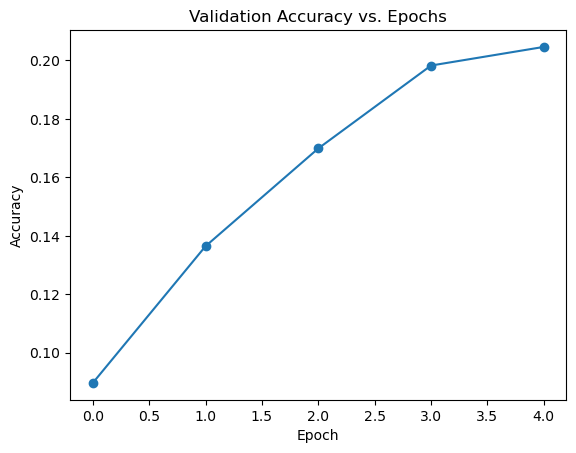

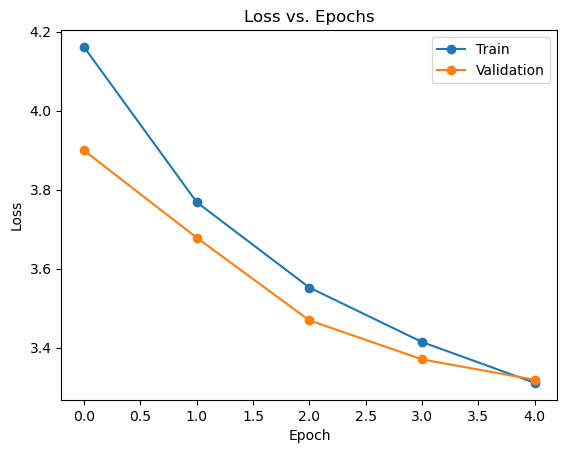

Test Loss (LeNet): 3.3182
Test Accuracy (LeNet): 0.2046
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             456
              ReLU-2            [-1, 6, 32, 32]               0
         MaxPool2d-3            [-1, 6, 16, 16]               0
            Conv2d-4           [-1, 16, 12, 12]           2,416
              ReLU-5           [-1, 16, 12, 12]               0
         MaxPool2d-6             [-1, 16, 6, 6]               0
            Linear-7                  [-1, 120]          69,240
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                  [-1, 100]           8,500
Total params: 90,776
Trainable params: 90,776
Non-trainable params: 0
-----------------------------------------

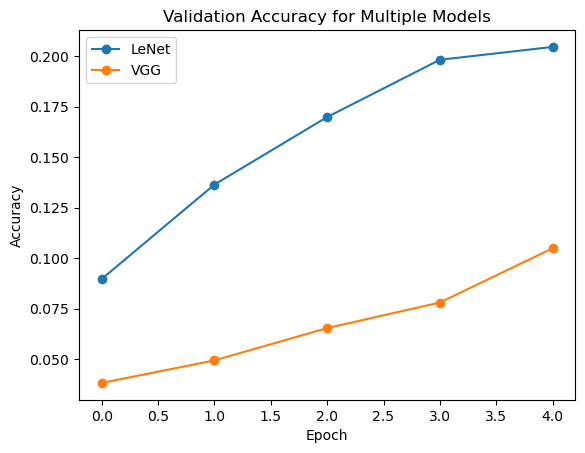

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


class LeNet(nn.Module):
    def __init__(self, num_classes=100):
        super(LeNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16 * 6 * 6, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16 * 6 * 6)  
        x = self.classifier(x)
        return x


epochs_lenet = 5
learning_rate_lenet = 0.001
grad_clip_value_lenet = 0.1


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNet().to(device)


optimizer_lenet = optim.Adam(lenet_model.parameters(), lr=learning_rate_lenet, weight_decay=1e-4)


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    val_loss = 0
    val_acc = 0
    for batch in val_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = model(images)
        loss = F.cross_entropy(out, labels)
        _, preds = torch.max(out, dim=1)
        val_loss += loss.item()
        val_acc += torch.sum(preds == labels).item() / len(labels)
    return {'val_loss': val_loss / len(val_loader), 'val_acc': val_acc / len(val_loader)}


def fit(model, train_loader, val_loader, optimizer, epochs, grad_clip=None):
    history = []
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            loss = F.cross_entropy(out, labels)
            loss.backward()

           
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(loss.item())

        
        result = evaluate(model, val_loader)
        avg_train_loss = sum(train_losses) / len(train_losses)
        history.append({
            'train_loss': avg_train_loss,
            'val_loss': result['val_loss'],
            'val_acc': result['val_acc']
        })
        print(f"Epoch {epoch+1}/{epochs}, train_loss: {avg_train_loss:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

    return history


transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = CIFAR100(root='data/', train=True, transform=transform, download=True)
val_dataset = CIFAR100(root='data/', train=False, transform=transform, download=True)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


history_lenet = fit(lenet_model, train_loader, val_loader, optimizer_lenet, epochs_lenet, grad_clip=grad_clip_value_lenet)


def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy vs. Epochs')
    plt.show()


def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-o', label='Train')
    plt.plot(val_losses, '-o', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()
    plt.show()


plot_accuracies(history_lenet)
plot_losses(history_lenet)


test_loader = DataLoader(val_dataset, batch_size=batch_size)
test_metrics_lenet = evaluate(lenet_model, test_loader)
print(f"Test Loss (LeNet): {test_metrics_lenet['val_loss']:.4f}")
print(f"Test Accuracy (LeNet): {test_metrics_lenet['val_acc']:.4f}")


torch.save(lenet_model.state_dict(), 'LeNet.pth')
summary(lenet_model, input_size=(3, 32, 32))


def plot_multiple_accuracies(histories, labels):
    for history, label in zip(histories, labels):
        accuracies = [x['val_acc'] for x in history]
        plt.plot(accuracies, '-o', label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy for Multiple Models')
    plt.legend()
    plt.show()


plot_multiple_accuracies([history_lenet, training_history_vgg], labels=['LeNet', 'VGG'])


In general, this code is similar to the previous VGG model code, except that the LeNet network structure is used and the function of comparing different models is added at the end. This can help readers understand and compare the performance differences of different deep learning models on the same task.